<a href="https://colab.research.google.com/github/Maxindrull2/APRENDIZAJE_AUTOMATICO_23_24/blob/main/AA_PRACTICA3_GRUPO_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diseño y entrenamiento de un sistema de redes de neuronas artificiales**

Asignatura: Aprendizaje Automático

Profesor: Carlos Emilio Rabazo Márquez

Grupo: A02

Integrantes: Natalia Iglesias, Sandra Millán y Ángel Pardo



***Librerias usadas:***

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.initializers import he_normal
from google.colab import files
import pickle
import tarfile
import pandas as pd
from tensorflow.python.ops.gen_array_ops import tensor_scatter_max_eager_fallback
import cv2
from PIL import Image
from keras.utils import to_categorical
from keras.datasets import cifar100
import math
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from skimage.transform import resize
from scipy.ndimage import rotate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras import regularizers
from keras.applications.inception_v3 import preprocess_input
from keras.layers import Layer
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, LayerNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.layers import Concatenate
from keras.layers import Input
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.image as mpimg

# **Introducción**
En esta práctica se tratará de crear un modelo que clasifique una base de datos con la mayor precisión posible. El conjunto de datos con el que se trabajará será **CIFAR-100**, que abarca una amplia representación de clases desde animales hasta personas y objetos diversos entre otras. Está compuesto por un total de 100 clases distintas que contienen 600 imágenes cada una. Dichas imágenes se dividirán en el conjunto de entrenamiento, formado por 500 imágenes, y el conjunto de prueba, con 100 imágenes por clase. Además, las 100 clases del CIFAR-100 se agrupan a la vez en 20 superclases. Cada imagen viene con una etiqueta "fina" (la clase a la que pertenece) y una etiqueta "gruesa" (la superclase a la que pertenece). La presencia de dos tipos de etiquetas asociadas a cada imagen enriquece aún más el conjunto de datos, permitiendo investigaciones tanto a nivel detallado como a nivel conceptual.

Para crear el modelo, se emplearán redes neuronales convolucionales. Esta manera de resolver el problema es una opción buena y efectiva debido a las características particulares de este tipo de datos y la arquitectura de las redes convolucionales. Estas redes proporcionan ventajas como, por ejemplo, las siguientes:

1. **Invariancia a desplazamientos:** Las capas convolucionales están diseñadas para ser invariantes a desplazamientos, lo que significa que pueden identificar patrones independientemente de su posición exacta en la imagen. Esta propiedad es crucial cuando se trata de reconocer objetos en diferentes partes de la imagen, como en el caso de CIFAR-100.

2. **Reducción de parámetros:** Las redes convolucionales reducen significativamente la cantidad de parámetros en comparación con redes totalmente conectadas. Esto es beneficioso en conjuntos de datos grandes como CIFAR-100, ya que ayuda a evitar el sobreajuste y a mejorar la generalización del modelo.

3. **Extracción jerárquica de características:** Las capas convolucionales permiten la extracción jerárquica de características. A medida que avanzas en las capas, la red puede aprender representaciones cada vez más complejas y abstractas de las características presentes en las imágenes, lo que es esencial para la clasificación de objetos en un conjunto de datos diverso como CIFAR-100.


Después de procesar y entender la base de datos que se empleará en esta práctica, se explicará en detalle en qué consiste las redes neuronales convolucionales y sus principales características.


Cargamos el dataset desde el fichero
(Por facilidad, si se desea, se pueden descomentar la opcion para cargar los datos directamente desde keras mas abajo)

In [ ]:
load = files.upload()

Saving cifar-100-python.tar.gz to cifar-100-python.tar.gz


In [ ]:
file_path = "cifar-100-python.tar.gz"
with tarfile.open(file_path, "r:gz") as tar:
    # Extraer el archivo de datos que contiene el conjunto de datos CIFAR-100
    tar.extract("cifar-100-python/train")
    tar.extract("cifar-100-python/test")

train_data = pd.read_pickle("cifar-100-python/train")
test_data = pd.read_pickle("cifar-100-python/test")

In [ ]:
# Cargar los datos desde el archivo Pickle
with open('cifar-100-python/train', 'rb') as file:
    cifar_data_train = pickle.load(file, encoding='bytes')

# Cargar los datos desde el archivo Pickle
with open('cifar-100-python/test', 'rb') as file:
    cifar_data_test = pickle.load(file, encoding='bytes')

# Obtener las imágenes y las etiquetas
train_images = cifar_data_train[b'data']
train_labels = cifar_data_train[b'fine_labels']
train_coarse_labels = cifar_data_train[b'coarse_labels']

# Obtener las imágenes y las etiquetas
test_images = cifar_data_test[b'data']
test_labels = cifar_data_test[b'fine_labels']
test_coarse_labels = cifar_data_test[b'coarse_labels']

# Dividir los datos en conjuntos de entrenamiento y prueba
# from sklearn.model_selection import train_test_split

print(train_images.shape)
print(test_images.shape)

(50000, 3072)
(10000, 3072)


Convertimos las imagenes a 32x32x3 considerando los colores, para ello deberemos cambiar las dimensiones y ordenes dados

In [ ]:
train_images = train_images.reshape((50000, 3, 32, 32))
train_images = np.transpose(train_images,(0,2,3,1))
test_images = test_images.reshape((10000, 3, 32, 32))
test_images = np.transpose(test_images,(0,2,3,1))
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
train_coarse_labels = np.array(train_coarse_labels)
test_coarse_labels = np.array(test_coarse_labels)



# **Verificación de las dimensiones**



Antes de comenzar, se comprueba que hay 50.000 imagenes de entrenamiento (500 por cada clase) y 10.000 de prueba (100 por cada clase) como se ha explicado previamente.

Además, es necesario cargar el conjunto de datos CIFAR-100 con la opción label_mode establecida en 'fine' para obtener las etiquetas específicas de clases y en 'coarse' para obtener las etiquetas de superclases.

Al observar las dimensiones que devuelve, además de confirmar las dimensiones de los conjuntos de datos, se vee que los datos son imágenes en color de 32x32 píxeles con 3 canales de color. Es decir, cada píxel en estas imágenes está representado por tres valores numéricos que indican la intensidad de los colores.

In [ ]:
#(train_images, train_labels), (test_images, test_labels)= cifar100.load_data(label_mode = 'fine')
#(_, train_coarse_labels), (_, test_coarse_labels)= cifar100.load_data(label_mode = 'coarse')
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(train_coarse_labels.shape)
print(test_coarse_labels.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000,)
(10000,)
(50000,)
(10000,)


Se comprueba que los datos tienen 100 categorías

In [ ]:
# Supongamos que y_train contiene las etiquetas
categorias_unicas = np.unique(train_labels)
numero_de_categorias = len(categorias_unicas)

print(f"Número de categorías: {numero_de_categorias}")
print("Categorías únicas:", categorias_unicas)

Número de categorías: 100
Categorías únicas: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


Se comprueba que hay 20 superclases

In [ ]:
supercategorias_unicas = np.unique(train_coarse_labels)
numero_de_superclases = len(supercategorias_unicas)

print(f"Número de superclases: {numero_de_superclases}")
print("Superategorías únicas:", supercategorias_unicas)

Número de superclases: 20
Superategorías únicas: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


Se confirma que hay el mismo numero de elementos por categoria

In [ ]:
# Inicializar un diccionario para contar las imágenes por categoría
category_count = {i: 0 for i in range(numero_de_categorias)}

# Contar las imágenes por categoría
for category in train_labels.flatten():
    category_count[category] += 1

# Imprimir la cantidad de imágenes por categoría
for category, count in category_count.items():
    print(f'Categoría {category}: {count} imágenes')

Categoría 0: 500 imágenes
Categoría 1: 500 imágenes
Categoría 2: 500 imágenes
Categoría 3: 500 imágenes
Categoría 4: 500 imágenes
Categoría 5: 500 imágenes
Categoría 6: 500 imágenes
Categoría 7: 500 imágenes
Categoría 8: 500 imágenes
Categoría 9: 500 imágenes
Categoría 10: 500 imágenes
Categoría 11: 500 imágenes
Categoría 12: 500 imágenes
Categoría 13: 500 imágenes
Categoría 14: 500 imágenes
Categoría 15: 500 imágenes
Categoría 16: 500 imágenes
Categoría 17: 500 imágenes
Categoría 18: 500 imágenes
Categoría 19: 500 imágenes
Categoría 20: 500 imágenes
Categoría 21: 500 imágenes
Categoría 22: 500 imágenes
Categoría 23: 500 imágenes
Categoría 24: 500 imágenes
Categoría 25: 500 imágenes
Categoría 26: 500 imágenes
Categoría 27: 500 imágenes
Categoría 28: 500 imágenes
Categoría 29: 500 imágenes
Categoría 30: 500 imágenes
Categoría 31: 500 imágenes
Categoría 32: 500 imágenes
Categoría 33: 500 imágenes
Categoría 34: 500 imágenes
Categoría 35: 500 imágenes
Categoría 36: 500 imágenes
Categoría 3

Vemos que efectivamente hay el mismo numero de elementos. Por lo que el dataset es adecuado. Además, como cada superclase está dividida exactamente en 5 categorías iguales tendremos de igual manera la misma representacion en cada una de las superclases.

Se va a asignar a cada clase su superclase

In [ ]:
valores_asociados = [0] * 100
for i in range(10000):
  valores_asociados[int(test_labels[i])] = int(test_coarse_labels[i])

print(valores_asociados)

[4, 1, 14, 8, 0, 6, 7, 7, 18, 3, 3, 14, 9, 18, 7, 11, 3, 9, 7, 11, 6, 11, 5, 10, 7, 6, 13, 15, 3, 15, 0, 11, 1, 10, 12, 14, 16, 9, 11, 5, 5, 19, 8, 8, 15, 13, 14, 17, 18, 10, 16, 4, 17, 4, 2, 0, 17, 4, 18, 17, 10, 3, 2, 12, 12, 16, 12, 1, 9, 19, 2, 10, 0, 1, 16, 12, 9, 13, 15, 13, 16, 19, 2, 4, 6, 19, 5, 5, 8, 19, 18, 1, 2, 15, 6, 0, 17, 8, 14, 13]


# **Representación**
Con el objetivo de familiarizarnos con la forma de los datos, se va a mostrar una de las imágenes. Concretamente, la imagen de la posición 9 en el conjunto de entrenamiento, eliminando las marcas en los ejes para obtener una visualización más limpia de la imagen.


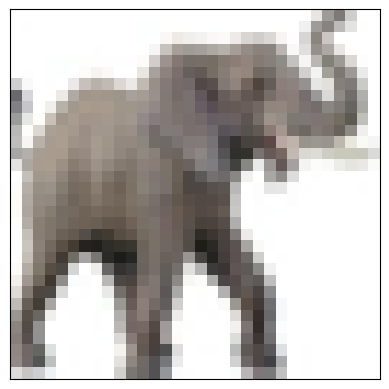

In [ ]:
imgRGB = train_images[9]
plt.xticks([]), plt.yticks([])
plt.imshow(imgRGB)
plt.show()

Se divide el conjunto de datos de entrenamiento en entrenamiento puro y validación

In [ ]:
train_images_pure = train_images[:40000]
train_labels_pure = train_labels[:40000]
train_coarse_labels_pure = train_coarse_labels[:40000]
validation_images = train_images[40000:]
validation_labels = train_labels[40000:]
validation_coarse_labels = train_coarse_labels[40000:]

# **Transformaciones**

**INGENIERÍA DE CARACTERÍSTICAS**

La ingeniería de características consiste en aplicar **transformaciones** sobre unos datos con el objetivo de mejorar el rendimiento del modelo. Esta etapa es crucial en el desarrollo de modelos predictivos, ya que la calidad de las características puede tener un impacto significativo en la capacidad del modelo para aprender patrones y realizar predicciones precisas. Si los datos se le presentan al modelo de una forma más fácil de interpretar, le facilitamos el trabajo y converge más rápido. Por lo tanto, la ingeniería de características puede mostrar información latente en los datos que no es evidente en las características originales. Algunas de estas transformaciones pueden ser rotaciones, cambios de escala, traslaciones, reflejos y otras operaciones que mantienen la etiqueta de la clase pero introducen variabilidad en las entradas.

En este modelo, se decide **aumentar los datos** mediante una transformación que voltea / le da la vuelta a cada una de las 50,000 imágenes originales, generando así 50,000 imágenes adicionales. Esto crea una versión reflejada horizontalmente de la imagen original. Además, las etiquetas del conjunto de entrenamiento original (train_labels y train_coarse_labels) se duplican para coincidir con el aumento de datos realizado en las imágenes.

Por otro lado, se muestran las **dimensiones** del conjunto de entrenamiento **después de la transformación** de aumento de datos para verificar cómo ha cambiado el tamaño del conjunto de entrenamiento (tamaño duplicado). Se ha pasado de (50.000, 32, 32, 3) a (100.000, 32, 32, 3).




In [ ]:
augmented_data = []
for i in range(40000):
  imgRGB = train_images_pure[i]

  imgRGB = np.flip(imgRGB, axis=1)

  augmented_data.append(imgRGB)

In [ ]:
train_images_pure = np.concatenate((train_images_pure, np.array(augmented_data)))
train_labels_pure = np.concatenate((train_labels_pure, train_labels_pure))
train_coarse_labels_pure = np.concatenate((train_coarse_labels_pure, train_coarse_labels_pure))

In [ ]:
print(train_images_pure.shape)
print(train_labels_pure.shape)
print(train_coarse_labels_pure.shape)
print(validation_images.shape)
print(validation_labels.shape)
print(validation_coarse_labels.shape)

(80000, 32, 32, 3)
(80000,)
(80000,)
(10000, 32, 32, 3)
(10000,)
(10000,)


# **Normalización de los datos**

La normalización de los datos previa al entrenamiento ayuda a la red neuronal a estabilizar y acelerar el proceso de entrenamiento, asegurarándose que todas las características contribuyen de manera equitativa al aprendizaje del modelo. Normalizar los datos previene posibles problemas de convergencia lenta o inestabilidad numérica que podrían surgir cuando los datos presentan escalas significativamente diferentes. Asimismo, al disminuir la variabilidad en las escalas de las características, se facilita al modelo aprender relaciones más relevantes entre estas, lo que mejora su capacidad de generalización a datos que no ha visto antes.
Se normaliza de forma que transforma las características para que estén en el rango [0,1]. Es decir, que tengan una media de 0 y una desviación estándar de 1.

El hecho de dividir entre 255 en el proceso se debe a que los píxeles de las imágenes están entre 0 y 255, representando cada valor de píxel la intensidad de la luz en ese píxel. En el caso de RGB (Rojo, Verde, Azul), un valor de cero representa la ausencia total de dicho color, representándose en color negro. Un valor de 255 repesenta la máxima intensidad del color al que corresponda.

Previamente, se probaron otras normalizaciones (como entre -1 y 1), las cuales mejoraban el modelo. Sin embargo, para este modelo concreto, la normalización entre 0 y 1 es la mejor.

In [ ]:
train_images = train_images.astype('float32')/255
train_images_pure = train_images_pure.astype('float32')/255
validation_images = validation_images.astype('float32')/255
test_images = test_images.astype('float32')/255

# **Aleatorización de los datos**
Mezclar los datos antes de entrenar un modelo es una buena costumbre debido a varias razones:

1. **Evitar el sesgo del orden de los datos:**
   - Cuando los datos están ordenados de alguna manera específica (por ejemplo, todas las instancias de una clase juntas), existe el riesgo de que el modelo aprenda patrones asociados con ese orden en particular y que cuando se le presente algo diferentes sufra grandes variaciones.

2. **Mejorar la generalización y aumentar la variabilidad del entrenamiento:**
   - Mezclar los datos ayuda a garantizar que el modelo no se especialice en patrones específicos de un subconjunto de los datos. Si los datos están organizados de cierta manera, el modelo puede funcionar bien solo para ese orden particular, pero podría tener un rendimiento deficiente en datos que no sigan la misma estructura. Además, la mezcla aleatoria introduce variabilidad en cada lote de entrenamiento, lo que puede ayudar al modelo a generalizar mejor en lugar de memorizar patrones específicos como se ha dicho. Esto es crucial para garantizar que el modelo se desempeñe bien en datos nuevos y no vistos.

3. **Facilitar la convergencia del modelo:**
   - La mezcla de datos puede ayudar a la convergencia más rápida del modelo durante el entrenamiento. Si los datos están organizados de manera desfavorable, el modelo podría tardar más en aprender los patrones relevantes.


# **One hot encoding**
Se realiza una codificación categórica de las etiquetas utilizando el método conocido como "one-hot encoding". Este proceso implica transformar las etiquetas en vectores que contienen tantos ceros como clases existan, y colocar un valor de 1 en la posición correspondiente a la clase a la que pertenece la etiqueta original.

En otras palabras, si previamente se tenía una clase con una etiqueta que indicaba que pertenecía a la clase 3, ahora se representará esa etiqueta como un vector en el cual habrá un 1 en la posición correspondiente a la clase 3, mientras que las demás posiciones contendrán ceros.

La función ```to_categorical``` se encarga de llevar a cabo esta transformación, convirtiendo los datos al formato de "one-hot encoding" y facilitando así el tratamiento de etiquetas categóricas en contextos de aprendizaje automático.

In [ ]:
from keras.utils import to_categorical

# Se reordenan los datos manteniendo los pares train_images~train_labels~train_coarse_labels asociados
def aleatorio(train_images, train_labels, train_coarse_labels):
    ale = list(zip(train_images, train_labels, train_coarse_labels))
    np.random.shuffle(ale)
    train_images, train_labels, train_coarse_labels = zip(*ale)
    return np.array(train_images), np.array(train_labels), np.array(train_coarse_labels)

train_images_pure, train_labels_pure, train_coarse_labels = aleatorio(train_images_pure, train_labels_pure, train_coarse_labels_pure)

train_labels = to_categorical(train_labels)
train_labels_pure = to_categorical(train_labels_pure)
validation_labels = to_categorical(validation_labels)
test_labels = to_categorical(test_labels)

# **Creación del modelo de red neuronal convolucional**

Se importan las capas y funciones necesarias de TensorFlow y Keras para construir el modelo de red neuronal convolucional (CNN) con características específicas como, entre otras, capas de convolución, pooling, inicializadores de pesos, capas densas.

# **Características adicionales / features**

Los ```num_features``` son una parte de ingeniería de características que consiste en realizar transformaciones específica a la imagen original para  para mejorar la capacidad del modelo a la hora de predecir al exponerlo a variaciones y patrones diferentes en los datos.. En nuestro modelo, se van a tomar 20 features (características adicionales). Esto significa que el modelo va a generar 20 transformaciones distintas a cada imagen de entrada, en las que en cada una se va a elegir una zona distinta de la imagen en la que se centrará para deducir patrones específicos. Esta zona en la que se enfoca será distinta en cada feature. Además, cada feature no tiene por qué elegir todo en la misma zona, sino que puede juntar distintas.

Además, de definir cuántas se usarán, se crea una capa de entrada separada para las características adicionales llamada ```additional_input```



In [ ]:
# Assuming x1, x2, x1x2, sin_x1, and sin_x2 are your additional features
num_features = 20

# Create a separate input layer for the additional features
additional_input = Input(shape=(num_features,))

# Create the image model
model = Sequential()

# **Redes neuronales convolucionales**

Las **redes convolucionales** son un tipo de redes profundas especializadas en procesar datos que tienen una estructura en forma de cuadrícula, siendo muy eficientes en áreas como reconocimiento de imágenes o detección de objetos. Esta es la razón por la cual se emplea esta herramienta para realizar esta práctica. Estas redes aprenden **patrones jerárquicos**. Es decir, aprenderá características más simples o generales las primeras capas (como pueden ser bordes o zonas de brillo en una imagen) y cada vez que se introduzca en una capa más profunda, las características que aprende son más complejas (diferentes niveles de abstracción). Además, la forma en que tiene para realizar las tareas es eficiente, pues asume que las entradas son imágenes y, por tanto, le da unas características que facilita el reconocimiento de ciertos elementos de una imagen. Las redes van a ir identificando líneas, bordes, tamaños relativos y muchos otros factores, que una vez aprendidos pueden reconocer en cualquier imagen, hasta obtener la solución. Además, si la red detecta que hay varios que aprenden lo mismo, lo detecta y se queda solo con uno, dándole menos refuerzo a aquellos que no aporten nada nuevo o útil (**retroalimentación negativa**).

Durante el entrenamiento, cada imagen va a pasar por red neuronal y los filtros se aplican sobre ellas. Cada uno de los filtros generará un mapa de características representativa de una parte de ella (**forward propagation**). Los pesos de los filtros se ajustarán para reducir el error al comparar la salida que se obtiene con la esperada. Si el filtro ayuda a detectar la imagen correctamente, su peso se verá reforzado, y sino, se modificará el filtro para que sí aporte información (**backward propagation**).

Estas redes se caracterizan por tener una capa de convolución, una **función de activación** para introducir no linealidades en el modelo y aprender patrones complejos, una **capa de pooling**, una de **flatten**, **capas densas** y, por último, la **capa de salida** para clasificar las imágenes por categorías. Un elemento importante que se añade para conseguirlo son los **filtros** (también llamados kernel) que se le van aplicando en la capa convolucional para crear un mapa de características, concepto que se explicará luego.


**Función de activación ELU (Exponential Linear Unit)**
La función de activación que se usará en este modelo es ELU (Exponential Linear Unit). Esta función proporciona ciertas ventajas:
* A diferencia de ReLU, ELU incluye valores negativos, lo que puede ser beneficioso al permitir que la activación sea tanto positiva como negativa. Además, tiene una suavidad en la zona negativa, lo que puede ser útil en problemas donde la suavidad es deseable.

* Otra ventaja es que ELU suele tener una menor probabilidad de provocar el problema de gradientes explosivos en comparación con ReLU.


# **Primeras capas**



* **Primera capa convolucional**   
    - Se añade una capa convolucional inicialmete con 128 filtros de tamaño (3, 3), especificando el paso de desplazamiento de los filtros durante la convolución como ```strides=(1, 1)```
    - Se aplica un relleno de ceros para mantener el tamaño de la salida igual al tamaño de la entrada (```padding='same'```). Se explica más abajo en qué consiste este concepto y por qué se toma esta decisión.
    - input_shape=(32, 32, 3) establece la forma de entrada para la primera capa, indicando imágenes de 32x32 píxeles con 3 canales (RGB).
    - **Mapa de características**: Los mapas de características son tensores 3D con una altura, ancho y profundidad. Es el resultado que se obtiene al reducir las dimensiones de la capa de entrada. Para ello, se introduce el concepto de stride, que consiste en un valor que es constante a lo largo del proceso de aprendizaje, está asociado a las capas y que representa el paso de avance. Es decir, si se tiene una ventana de 5x5 para recorrer la capa y el stride es 1, entonces esa ventana de 5x5 solo se moverá una posición hacia la derecha. Además, cuanto más alto es el stride, más pequeño será el mapa de características. Esto se debe a que se realizan menos pasos de avances, recorriendo antes toda la capa de entrada. Las dimensiones del mapa de características que se generan en una ventana axa (a es un natural) dimensión de la capa de entrada menos a (tamaño ventana) más 1.Otro efecto de un stride alto es que las imágenes tienen peor calidad, pues se centra más en características globales.  

**Otros hiperparámetros de la capa convolucional**

* Un hiperparámetro de esta capa es el **padding**, que consiste en agregar valores adicionales de ceros alrededor de la entrada antes de aplicar la operación de convolución. Es decir, antes de deslizar la ventana y generar el mapa de características.

  Para no inlcuir relleno, se hace ```padding = 'valid'```. En dicho caso, el tamaño del mapa de características resultante es más pequeño que el tamaño de la entrada.

  Si queremos añadirle este relleno, se hace ```padding = 'same'```, y rellena los **huecos vacíos con ceros**. Esto quiere decir que se agrega suficiente relleno para mantener el tamaño del mapa de características resultante igual al tamaño de la entrada, de manera que la ventana de convolución pueda recorrer toda la imagen sin salirse de los bordes, pues muchas veces la imagen proporciona información valiosa en los bordes que sin el padding podría no ser capaz de capturar.

  Por lo tanto, esto nos perimte conservar el tamaño de las características de forma que el tamaño de los mapas de características no se reduzca demasiado rápido y permita que la red aprenda una variedad más rica y variada de características a diferentes escalas y posiciones. Además, otra ventaja que ofrece está opción es la ayuda para evitar el **sobreentrenamiento**. Esto se debe a que las capas pueden aprender de una cantidad más amplia de características sin centrarse excesivamente en detalles específicos de las imágenes de entrenamiento. Por todas estas razones, se incluye el padding en nuestro modelo.


* **Capa de normalización por batches (```BatchNormalization```)**:
  - Esta capa normaliza las activaciones de la capa anterior, ayudando a estabilizar y acelerar el entrenamiento. Durante el entrenamiento, para cada mini-batch, se calculan la media y la desviación estándar de las activaciones de cada neurona en el lote. Las activaciones de cada neurona se normalizan restando la media del lote y dividiendo por la desviación estándar del lote. Esta técnica ayuda a evitar problemas como el desvanecimiento del gradiente al mantener las activaciones en rangos más estables. Además, también facilita el entrenamiento, haciéndolo más rápido y estable al normalizar las activaciones y reducir la dependencia de la inicialización de pesos.

* Se añade otra capa convolucional con 128 filtros al igual que en la primera capa convolucional, así como otra capa de normalización por batches.

* **Capa de max pooling**
  - Estas capas sirven para reducir la dimensionalidad espacial de los mapas de características sin perder información importante y proporciona cierta invarianza a la translación y a pequeñas variaciones en la posición de las características, convirtiendo la red más eficiente y menos sensible a las variaciones en la posición de las características en la entrada. Al seleccionar solo el valor máximo en cada región, la operación reduce la dimensionalidad de la entrada. Esto es útil para limitar la cantidad de parámetros y operaciones en capas subsiguientes.

  - Estas se aplican inmediatamente después de la capa convolucional para simplificar la información obtenida y crear otra versión pero condensada. Para ello, se toma una ventana de cierto tamaño y se simplifica igual que cuando se simplifica en la capa convolucional. En este caso, hemos elegido una ventana de (2,2). Es decir, que en dicha ventana con cuatro puntos, la capa de pooling solo se quedará con uno de estos cuatro valores. Para decidir cuál se usa, hay varios criterios. En esta práctica se empleará el criterior del máximo, es decir, se queda con el mayor valor de los cuatro

* **Capa de dropout**
  - La capa de dropout es una técnica de regularización utilizada para prevenir el sobreajuste (overfitting). Durante el entrenamiento, en cada iteración, cada neurona de la capa de dropout tiene una probabilidad de ser "apagada" o retirada; es decir, que toma valor cero. Esto se hace seleccionando al azar (de manera estocástica) si la unidad debe ser apagada o no. La probabilidad de retirar un número de características de salida de la capa durante el entrenamiento se controla mediante el parámetro de dropout, que suele ser un valor entre 0.2 y 0.5, representando la fracción de características que se ponen a cero en cada iteración.

    Al eliminar aleatoriamente unidades durante el entrenamiento, el modelo se vuelve más robusto y menos propenso a depender fuertemente de ciertas conexiones, lo que puede ayudar a mejorar su capacidad para generalizar, así como prevenir el sobreentrenamiento al forzar a la red a no depender demasiado de características específicas sino más robustas.

    En nuestro modelo, se decide darle a dropout un valor de 0,3. Es decir, se van a reducir los resultado en un 30% (la mitad de las características se ponen a cero).


In [ ]:
# 1º capa convolucional
model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', input_shape=(32, 32, 3), activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

* **Otras capas de convolución**
  - Se crean otras dos capas de convolución, manteniendo las mismas características que la primera, variando solamente el valor del dropout. Esto se debe a que en cada capa, el número de filtros va a ir aumentando, pues a medida que se va profundizando en las capas hacen falta más filtro para reconocer características. Por lo tanto, al igual que aumenta este número, también tendrá que aumentar el número de características que se retiran.

* **Ultimas capas**

 -  Por último, se añade la capa flatten para aplanar el mapa de características y después conectarlas a las capas densas para la clasificación o regresión. También se concatenan las características aplanadas de la imagen con las características adicionales proporcionadas.

In [ ]:
# 2º capa convolucional
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# 3º capa convolucional
model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Capa para aplanar los datos
model.add(Flatten())

# Concatenación con Características Adicionales
combined_model = Concatenate()([model.output, additional_input])

**Capas Completamente Conectadas:**
-   Después de las capas convolucionales y de pooling, se introducen capas totalmente conectadas para combinar las características aprendidas y aprender representaciones más abstractas. La elección del número de neuronas es un hiperparámetro que se debe decidir según la complejidad del problema. Luego, se aplica normalización por lotes y un dropout con una tasa del 50% por las razones que ya se han explicado. Similar a la capa anterior, se define una segunda capa totalmente conectada, donde se reduce el número de neuronas ayudando así a concentrar información relevante y reducir la complejidad del modelo.

**Capa de Salida:**
  - La capa de salida tiene 100 neuronas (correspondientes a las clases en el conjunto de datos CIFAR-100) y utiliza la función de activación 'softmax' para convertir las salidas en probabilidades, permitiendo que el modelo realice una clasificación multiclase.

In [ ]:
# Primera capa totalmente conectada
combined_model = Dense(1024, activation='elu')(combined_model)
combined_model = BatchNormalization()(combined_model)
combined_model = Dropout(0.5)(combined_model)

# Segunda capa totalmente conectada
combined_model = Dense(512, activation='elu')(combined_model)
combined_model = BatchNormalization()(combined_model)
combined_model = Dropout(0.5)(combined_model)

# Capa de salida
combined_model = Dense(100, activation='softmax')(combined_model)

# Modelo final: Se junta el modelo original (model) con las características adicionales (additional_input)
final_model = tf.keras.Model(inputs=[model.input, additional_input], outputs=combined_model)

# **Entrenamiento**
A continuación, se detalla el proceso de entrenamiento. Para ello, especificamos primero el optimizador que se va a utilizar. En este caso, se empleará Adam con una tasa de aprendizaje de 0.01.
Adam es un optimizador popular que se adapta de manera dinámica durante el entrenamiento, ajustando las tasas de aprendizaje para cada parámetro de la red de manera individual.

**Optimizador Adam**
-   Adam (Adaptive Moment Estimation) es un algoritmo de optimización que junta los puntos fuertes de los algoritmos RMSprop y del momentum para potenciar el proceso de aprendizaje en un modelo. Similar al momentum, Adam emplea **estimaciones** del **momento** y de la magnitud de los **gradientes** previos para actualizar los parámetros del modelo en cada iteración. No obstante, en lugar de utilizar una tasa de aprendizaje constante para todos los parámetros, Adam ajusta **dinámicamente** la tasa de aprendizaje de cada parámetro individual basándose en sus estimaciones del momento y la magnitud del gradiente. Este enfoque posibilita que el modelo se adapte de manera más eficaz y precisa a los datos de entrenamiento, resultando potencialmente en una mayor precisión de las predicciones en comparación con otros métodos de optimización. Por estas razones, este es el optimizador que se decide usar para nuestro modelo.

**La tasa de aprendizaje**
-   La tasa de aprendizaje es un hiperparámetro importante que hay que decidir para determinar el tamaño de los pasos que el algoritmo de optimización toma al actualizar los pesos del modelo durante el entrenamiento. Un valor u otro puede afectar al rendimiento del modelo. Por ejemplo, si es muy alto va a converger más rápido al principio, ya que los pesos se actualizan en pasos más grandes. Sin embargo, el riesgo de hacer esto es que puede no converger al oscilar de un punto a otro sin ninguna estabilidad. También podría ser que converga pero se quede en un mínimo que no sea el más óptimo. Por otro lado, si la tasa de aprendizaje es baja, aunque la convergencia sea más lenta, será más segura y generalmente converge a la solución. La desventaja de esto es la cantidad de tiempo que puede llegar a tardar y la posibilidad de quedarse estancado en mínimos locales. En este modelo se opta por usar una tasa del 0.01, que se considera un valor intermedio.


**Decisión de hiperparámetro al compilar el modelo**
  - Se compila el modelo para definir cómo el modelo debe aprender y evaluar los datos durante el entrenamiento. Se le asigna la **función de pérdida** como 'categorical_crossentropy', pues estamos tratando un problema de clasificación multiclase, y la **métrica de precisión** ('accuracy') para poder ver la precisión del modelo.

**Configuración de la Callback ReduceLROnPlateau**
-   Se crea un callback de reducción de la tasa de aprendizaje (ReduceLROnPlateau) que ajustará automáticamente la tasa de aprendizaje durante el entrenamiento. La reducción se activará si no hay mejora en la precisión de la validación (val_accuracy) o en el valor de la perdida de validación (val_loss) después de dos épocas (patience=1), y reducirá la tasa de aprendizaje multiplicándola por un factor de 0.1. El valor mínimo de la tasa de aprendizaje se establece en 1e-5.




In [ ]:
# Decisión del optimizador y tasa de aprendizaje
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Configuración de la Callback ReduceLROnPlateau:
reduce_lr1 = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.1,
                              patience=2,
                              min_lr=1e-5)

reduce_lr2 = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=1e-5)

# Se utiliza para generar matrices de números aleatorios entre 0 y 1. Estos números se utilizan como características adicionales.
# Cada fila de estas matrices representa un conjunto de características adicionales para una imagen específica.
train_additional_features = np.random.random((len(train_images_pure), num_features))
validation_additional_features = np.random.random((len(validation_images), num_features))

# Se entrena el modelo con callback ReduceLROnPlateau
history2 = final_model.fit([train_images_pure, train_additional_features], train_labels_pure, batch_size=64,
                            epochs=30,
                            validation_data=([validation_images, validation_additional_features], validation_labels),
                            callbacks=[reduce_lr1,reduce_lr2])

Epoch 1/30
1250/1250 [==============================] - 86s 55ms/step - loss: 3.7923 - accuracy: 0.1488 - val_loss: 2.8822 - val_accuracy: 0.2765 - lr: 0.0010
Epoch 2/30
1250/1250 [==============================] - 70s 56ms/step - loss: 2.5601 - accuracy: 0.3367 - val_loss: 2.1613 - val_accuracy: 0.4212 - lr: 0.0010
Epoch 3/30
1250/1250 [==============================] - 71s 57ms/step - loss: 2.0743 - accuracy: 0.4380 - val_loss: 1.9253 - val_accuracy: 0.4735 - lr: 0.0010
Epoch 4/30
1250/1250 [==============================] - 70s 56ms/step - loss: 1.7879 - accuracy: 0.5046 - val_loss: 1.6602 - val_accuracy: 0.5365 - lr: 0.0010
Epoch 5/30
1250/1250 [==============================] - 71s 57ms/step - loss: 1.5524 - accuracy: 0.5624 - val_loss: 1.6706 - val_accuracy: 0.5447 - lr: 0.0010
Epoch 6/30
1250/1250 [==============================] - 70s 56ms/step - loss: 1.3888 - accuracy: 0.6031 - val_loss: 1.4562 - val_accuracy: 0.5931 - lr: 0.0010
Epoch 7/30
1250/1250 [========================

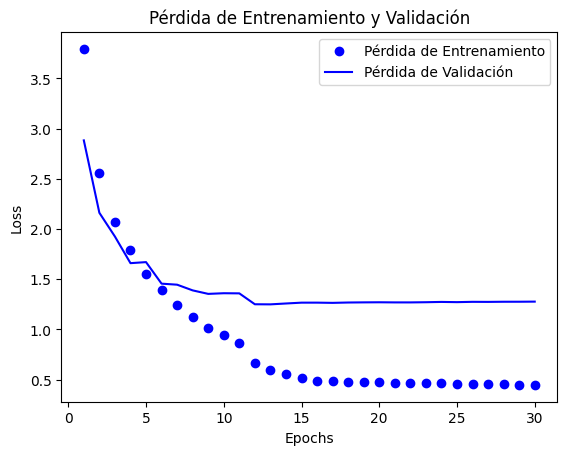

In [ ]:
history_dict = history2.history
history_dict.keys()

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" es para "punto azun"
plt.plot(epochs, loss, 'bo', label='Pérdida de Entrenamiento')
# "b" es para "linea continua azul"
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

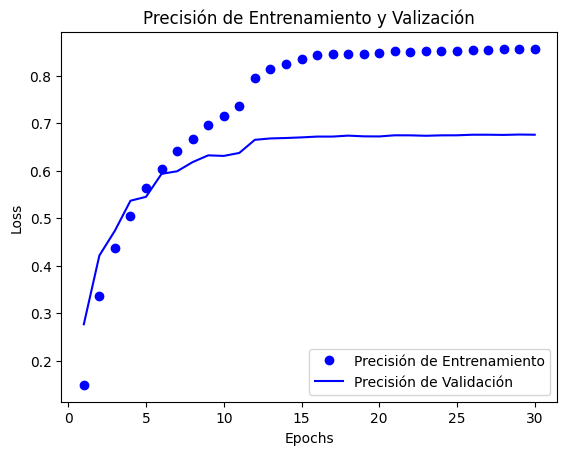

In [ ]:
plt.clf()   # Limpia la figura
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, 'b', label='Precisión de Validación')
plt.title('Precisión de Entrenamiento y Valización')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Acorde a estas dos ultimas gráficas podemos seleccionar cual es el número óptimo de epocas a entrenar nuestro modelo. Esto lo podemos deducir viendo a partir de que época la precisión y la perdida de nuestros datos de validación dejan de mejorar, en nuestro caso, la época 15.

**Entrenamiento ultimo**
Del modelo anterior sacamos que el número optimo de épocas a emplear es de 15, pero además tambien obtenemos el mejor learning rate a emplear en cada época, aplicandose de 0.001 en las 13 primeras y de 0.0001 en las 2 siguientes.

Conociendo estos datos no nos es necesario emplear un conjunto de validación, por lo que procederemos a emplear todos los datos de entrenamiento para nuestro modelo final.

Añadimos las imagenes simétricas

In [ ]:
augmented_data = []
for i in range(50000):
  imgRGB = train_images[i]

  imgRGB = np.flip(imgRGB, axis=1)

  augmented_data.append(imgRGB)

In [ ]:
train_images = np.concatenate((train_images, np.array(augmented_data)))
train_labels = np.concatenate((train_labels, train_labels))
train_coarse_labels = np.concatenate((train_coarse_labels, train_coarse_labels))

In [ ]:
train_images_pure, train_labels_pure, train_coarse_labels = aleatorio(train_images_pure, train_labels_pure, train_coarse_labels_pure)


Entrenamos de nuevo nuestro modelo añadiendo un LearningRateScheduler que determina el learning rate segun la época en la que se este

In [ ]:
# Assuming x1, x2, x1x2, sin_x1, and sin_x2 are your additional features
num_features = 20

# Create a separate input layer for the additional features
additional_input = Input(shape=(num_features,))

# Create the image model
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', input_shape=(32, 32, 3), activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Convolutional layer 2
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Convolutional layer 3
model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# Flatten layer
model.add(Flatten())

# Concatenate the flattened image features with the additional features
combined_model = Concatenate()([model.output, additional_input])

# Fully-connected layer 1
combined_model = Dense(1024, activation='elu')(combined_model)
combined_model = BatchNormalization()(combined_model)
combined_model = Dropout(0.5)(combined_model)

# Fully-connected layer 2
combined_model = Dense(512, activation='elu')(combined_model)
combined_model = BatchNormalization()(combined_model)
combined_model = Dropout(0.5)(combined_model)

# Output layer with softmax activation for 100 classes in CIFAR-100
combined_model = Dense(100, activation='softmax')(combined_model)

# Create the combined model
final_model = tf.keras.Model(inputs=[model.input, additional_input], outputs=combined_model)

# Configure the optimizer with the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

def lr_schedule(epoch):
    if epoch < 13:
        return 0.001
    else:
        return 0.0001

# Assuming you have the additional features in a numpy array called additional_features
# Make sure to preprocess them appropriately
train_additional_features = np.random.random((len(train_images), num_features))
test_additional_features = np.random.random((len(test_images), num_features))

# Training the model with the callback ReduceLROnPlateau
history2 = final_model.fit([train_images, train_additional_features], train_labels, batch_size=64,
                            epochs=15,
                            callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/15
1563/1563 [==============================] - 92s 56ms/step - loss: 3.5400 - accuracy: 0.1886 - lr: 0.0010
Epoch 2/15
1563/1563 [==============================] - 87s 56ms/step - loss: 2.3461 - accuracy: 0.3812 - lr: 0.0010
Epoch 3/15
1563/1563 [==============================] - 86s 55ms/step - loss: 1.9071 - accuracy: 0.4774 - lr: 0.0010
Epoch 4/15
1563/1563 [==============================] - 86s 55ms/step - loss: 1.6341 - accuracy: 0.5433 - lr: 0.0010
Epoch 5/15
1563/1563 [==============================] - 87s 56ms/step - loss: 1.4397 - accuracy: 0.5891 - lr: 0.0010
Epoch 6/15
1563/1563 [==============================] - 87s 55ms/step - loss: 1.2861 - accuracy: 0.6281 - lr: 0.0010
Epoch 7/15
1563/1563 [==============================] - 88s 56ms/step - loss: 1.1629 - accuracy: 0.6587 - lr: 0.0010
Epoch 8/15
1563/1563 [==============================] - 88s 56ms/step - loss: 1.0556 - accuracy: 0.6875 - lr: 0.0010
Epoch 9/15
1563/1563 [==============================] - 87s 56ms

Para ver la adecuación del modelo la evaluamos en base a datos que no ha visto nunca, estos son, los datos de test.

In [ ]:
final_model.evaluate([test_images, test_additional_features], test_labels)

313/313 [==============================] - 3s 9ms/step - loss: 1.1696 - accuracy: 0.6990


[1.169616460800171, 0.6990000009536743]

Se ha obtenido un 70% de acierto sobre los datos de test, lo cual significa que nuestro modelo es capaz de acertar bastantes clases.

Sin embargo, tambien tenemos las superclases, por lo que procederemos a ver cuantas se han acertado mediante los valores asociados a las subclases

In [ ]:
predicciones = final_model.predict([test_images, test_additional_features])

313/313 [==============================] - 3s 8ms/step


In [ ]:
count = 0
for i in range(10000):
  if valores_asociados[np.argmax(predicciones[i])]==valores_asociados[np.argmax(test_labels[i])]:
    count += 1

print(count/100)

80.35


Se aciertan un 80% de las superclases, lo cual indica que nuestro modelo es bastante acertado en esta característica

# **Matriz de confusión**

Se genera la matriz de confusión cm usando las etiquetas verdaderas y las etiquetas predichas. El objetivo de la matriz es evaluar el rendimiento de un modelo al comparar las predicciones con los los valores reales. Para ello, se muestra el número de instancias de cada clase que han sido clasificadas correctamente o incorrectamente por el modelo.

Se configura el tamaño de la figura de la matriz con plt.figure(figsize=(10, 6)). Además, las etiquetas de los ejes x e y representan las clases predichas y verdaderas, respectivamente.

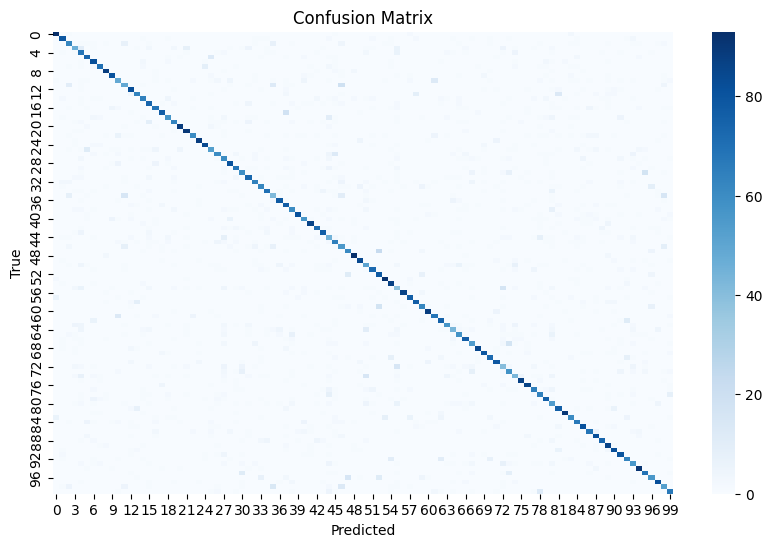

In [ ]:
# Assuming 'model' is your trained model and 'test_images', 'test_labels' are your test data
predictions = predicciones
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Convert one-hot encoded labels to class labels
true_labels = np.argmax(test_labels, axis=1)

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

La matríz de confusión nos ayuda a ver que el modelo tiene la capacidad de predecir todas las clases, esto lo sabemos debido a que toda la diagonal, que son los aciertos, esta en un color oscuro, lo cual significa que hay un número contundente de aciertos.

# Ejemplos gráficos de las predicciones

Creamos las funciones que nos lo representen de manera adecuada

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  #La función ('inshow') de Matplotlib permite mostrar imagenes, en este caso en
  # escala de grises, ya que el mapa de color ('cmap') es ('plt.cm.binary'),
  # donde 0 es negro y 1 es blaco, utilizando así que las imagenes están en forma
  # de porcentajes.
  plt.imshow(img, cmap=plt.cm.binary)

  # La función ('argmax') de Numpy, devuelve el indice del valor máximo en el array
  # , lo que significa que ('predicted_label') ahora contiene la etiqueta predicha.
  predicted_label = np.argmax(predictions_array)
  if predicted_label == np.argmax(true_label):
    color = 'blue'
  else:
    color = 'red'

  # La siguinte función de Matplotlib establece la etiqueta del eje X de la imagen,
  # la etiqueta consta de tres numeros:
  # 1 - Mustra la opción de la etiqueta de la imagen predicha por el modelo
  # 2 - Muestra en porcentaje de acierto de la imagen
  # 3 - Muestra el numero de la etiqueta correcta
  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                np.argmax(true_label)),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(100))
  plt.yticks([])

  # La siguiente función de la biblioteca 'matplotlib' crea un gráfico de barras
  # con 10 barras (nº de etiquetas), donde las alturas estan dadas por los
  # los valores ('predictions_array'), siendo todas de color verde, menos
  # el valor de la etiqueta, que en caso de coincidir con el valro de la prediccion
  # es negra, y en caso contrario, la barra de la etiqueta sera negra y la
  # predicción roja
  thisplot = plt.bar(range(100), predictions_array, color="#00FF00")
  # Implementaremos 00FF00 en vez de 777777, para poder visualizar mejor los porcentajes
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.argmax(true_label)].set_color('black')

Mostramos las diez primeras imagenes y sus predicciones

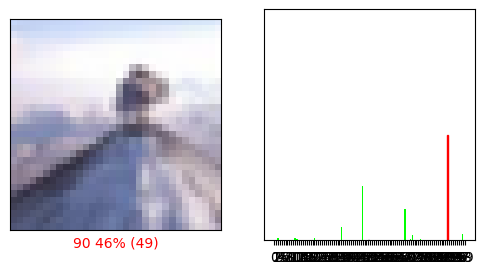

<Figure size 640x480 with 0 Axes>

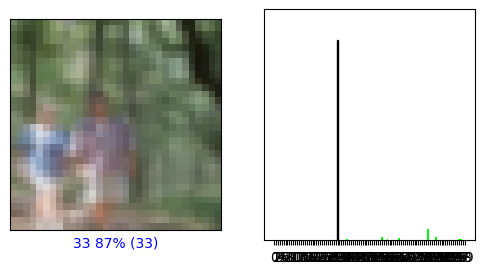

<Figure size 640x480 with 0 Axes>

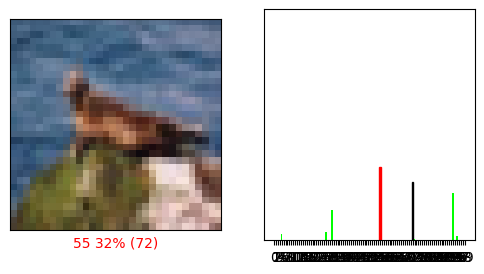

<Figure size 640x480 with 0 Axes>

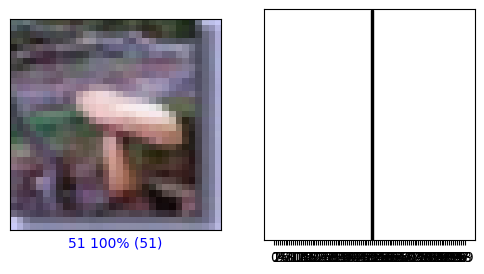

<Figure size 640x480 with 0 Axes>

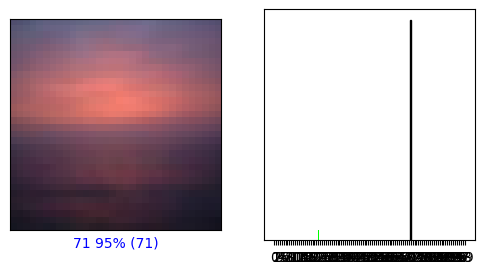

<Figure size 640x480 with 0 Axes>

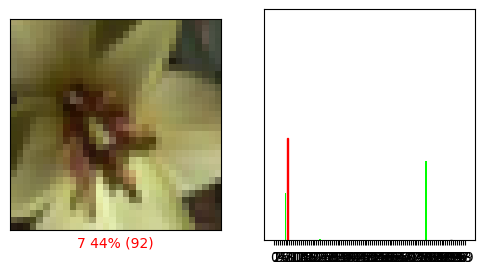

<Figure size 640x480 with 0 Axes>

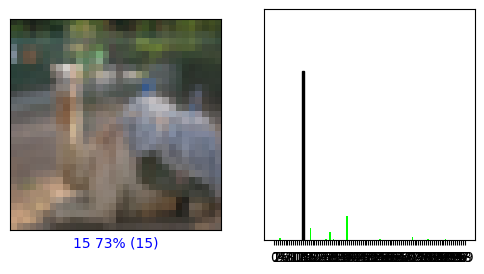

<Figure size 640x480 with 0 Axes>

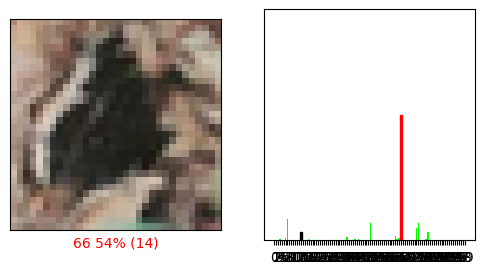

<Figure size 640x480 with 0 Axes>

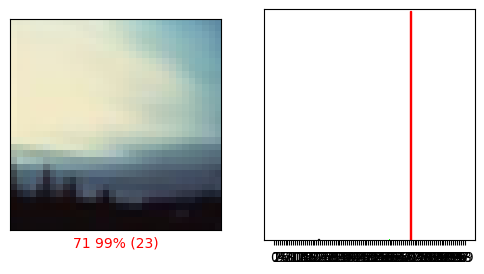

<Figure size 640x480 with 0 Axes>

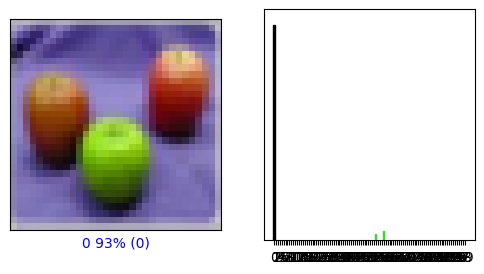

<Figure size 640x480 with 0 Axes>

In [ ]:
for j in range(10):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(j, predicciones[j], test_labels, test_images)
  plt.subplot(1,2,2)
  plot_value_array(j, predicciones[j],  test_labels)
  plt.show()
  plt.clf()

# **NÚMERO DE PARÁMETROS**

Se ha creado un modelo para el conjunto de datos CIFAR-100, que demuestra una capacidad considerable para aprender y representar patrones complejos en las imágenes. Con tres capas convolucionales, una capa de aplanamiento, una concatenación con 20 características y dos capas densas, el modelo tiene un total de 13,569,252 parámetros entrenables. Esta cantidad de parámetros indica una red neuronal relativamente grande y poderosa que puede capturar características detalladas y relaciones en los datos de entrada.

Además, no solo consideramos el crecimiento horizontal, que se refiere al aumento en el número de neuronas en cada capa, sino también el crecimiento vertical de la red. El crecimiento horizontal se relaciona con la complejidad y la capacidad de cada capa para aprender patrones específicos, mientras que el crecimiento vertical se refiere a la profundidad de la red, es decir, el número total de capas.

La presencia de tres capas convolucionales seguidas de una capa de aplanamiento y una concatenación con 20 características ilustra el crecimiento vertical del modelo. Estas capas convolucionales permiten la extracción de características espaciales en las imágenes, y la concatenación agrega una dimensión adicional a la representación de los datos.

Posteriormente, con dos capas densas, la red realiza operaciones más abstractas y busca correlaciones entre las características aprendidas en las capas anteriores. Este crecimiento vertical contribuye a la capacidad del modelo para entender relaciones complejas y realizar tareas de clasificación en el conjunto de datos CIFAR-100.

In [ ]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_6_input (InputLayer  [(None, 32, 32, 3)]          0         []                            
 )                                                                                                
                                                                                                  
 conv2d_6 (Conv2D)           (None, 32, 32, 128)          3584      ['conv2d_6_input[0][0]']      
                                                                                                  
 batch_normalization_8 (Bat  (None, 32, 32, 128)          512       ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                            


**Capas convolucionales:**

Los parámetros entrenables incluyen los pesos de los filtros y los sesgos asociados a cada filtro. La cantidad total de parámetros entrenables en una capa convolucional se calcula de la siguiente manera:

*Parámetros = (F × F × C + 1) × K*

*   K: es el número de filtros
*   F × F: es el tamaño del filtro
*   C :es el número de canales en la entrada (RGB = 3)
* Otros factores que pueden cambiar el número de parámetros son: padding ampliando el tamaño de la imagen original y stride siendo este la velocidad con la que cambia y por la que se dividirian el número de parámetros


**Batch_normalization:**

La capa de Batch Normalization tiene cuatro parámetros entrenables por cada característica en la capa anterior. La cantidad total de parámetros son:

*Parámetros = 4 × C*

*   C: número de canales en la entrada.
*   Gamma (ganancia): Escala los datos normalizados
*   Beta (sesgo): Desplaza los datos normalizados
*   Media móvil: Media móvil que se utiliza durante la inferencia para normalizar los datos
*   Varianza móvil: Varianza móvil que se utiliza durante la inferencia para normalizar los datos


**Capa Densa:**

 La Capa Densa en nuestro modleo es una capa totalmente conectada (densa), y su fórmula para calcular la cantidad total de parámetros es la siguiente:

 *Parámetros = ( Número de entradas + 1 ) × Número de neuronas*

 *  Número de neuronas: es la cantidad de nodos en la capa
 *  Número de entradas: es la cantidad de nodos en la capa anterior (en este caso, la salida de la capa dropout_18).
 *  +1: es el sesgo (bias) asociado a cada neurona.


# Parámetros entrenables

**Convolutional layer 1**

1.   Capa de Entrada: no tiene parámetros entrenables
2.   Capa convolucional: (3 × 3 × 3 + 1) × 128 = 3584 parámetros entrenables
3.   Bach_normalization: (2 × 128) = 256 parámetros NO entrenables y (2 × 128) = 256 parámetros entrenables
4.   Capa convolucional: (3 × 3 × 128 + 1) × 128 = 147584 parámetros entrenables
5.   Bach_normalization: (2 × 128) = 256 parámetros NO entrenables y (2 × 128) = 256 parámetros entrenables
6.   Max Pooling: no tiene parámetros entrenables. Pero reduce las dimensiones espaciales a la mitad (16 × 16)
7.   Dropout: no tiene parámetros entrenables

**Convolutional layer 2**

8.   Capa convolucional: (3 × 3 × 128 + 1) × 256 = 295.168 parámetros entrenables
9.   Bach_normalization: (2 × 256 ) = 512 parámetros NO entrenables y (2 × 256 ) = 512 parámetros entrenables
10.   Capa convolucional: (3 × 3 × 256 + 1) × 256 = 590.080 parámetros entrenables
11.   Bach_normalization: (2 × 256 ) = 512 parámetros NO entrenables y (2 × 256 ) = 512 parámetros entrenables
12.   Max Pooling: no tiene parámetros entrenables
13.   Dropout: no tiene parámetros entrenables

**Convolutional layer 3**

14.   Capa convolucional: (3 × 3 × 256 + 1) × 512 = 1.180.160 parámetros entrenables
15.   Bach_normalization: (2 × 512 ) = 1024 parámetros NO entrenables y (2 × 512 ) = 1024 parámetros entrenables
16.   Capa convolucional: (3 × 3 × 512 + 1) × 512 = 2.359.808 parámetros entrenables
17.   Bach_normalization: (2 × 512 ) = 1024 parámetros NO entrenables y (2 × 512 ) = 1024 parámetros entrenables
18.   Max Pooling: no tiene parámetros entrenables
19.   Dropout: no tiene parámetros entrenables

**Flatten layer**

20.   Flatten: no tiene parámetros entrenables

**Concatenate the flattened image features with the additional features**

21.   Capa de Entrada: no tiene parámetros entrenables
22.   Concatenación: no tiene parámetros entrenables

**Fully-connected layer 1**

23.   Capa Densa: (8192×20 + 1) × 1024  = 8.410.112 parámetros entrenables. Es importante, destacar que hay 20 features y 8192 son los números de entrada, por cada feature.
17.   Bach_normalization: (2 × 1024  ) = 2048 parámetros NO entrenables y (2 × 1024  ) = 2048 parámetros entrenables
19.   Dropout: no tiene parámetros entrenables

**Fully-connected layer 2**

23.   Capa Densa: (1024 + 1) × 512  = 524.800 parámetros entrenables.
17.   Bach_normalization: (2 × 512 ) = 1024 parámetros NO entrenables y (2 × 512 ) = 1024 parámetros entrenables
19.   Dropout: no tiene parámetros entrenables

**Output layer**


23.   Última capa: (512 + 1) × 100  = 51.300 parámetros entrenables.





# Total de parámetros:

**Parámetros entrenables**

3584 + 256 + 147584 + 256 + 295.168 + 512 + 590.080 + 512 + 1.180.160 + 1024 + 2.359.808 + 1024 + 8.410.112 + 2048 + 524.800 + 1024 + 51.300 = 13569252

**Parámetros NO entrenables**

256 + 256 + 512 + 512 + 1024 + 1024 + 2048 + 1024 = 6656

**Parámetros totales**

6656 + 13569252 = 13575908

# **Conclusión**
**Conclusión del modelo:**

En esta práctica de redes convolucionales aplicadas sobre el conjunto de datos CIFAR 100, el objetivo era obtener la mayor precisión posible del modelo realizando los cambios necesarios en la estructura de la red y los hiperparámetros (el stride, padding, numero y tipos de capas, función de activación y tasa de droput, entre otros).

Antes de la creación del modelo, se han tenido que dividir los datos en los conjuntos de entrenamiento, validación y de prueba. Para ello, se han ido probando distintas combinaciones, de forma que mejore la precisión del modelo. Para ello, se han ido disminuyendo la cantidad de imágenes que se utilizaban para la validación para así añadirlas al conjunto de entrenamiento. Se han ido modificando el tamaño de estos conjuntos de forma que la precisión mejore pero que a la vez sea una cantidad suficientemente representativa, dejando finalmente como la opción más óptima un 80% de las imágenes para entrenamiento y el otro 20% de ellas para validación.

También se han normalizado los datos y aleatorizado para aumentar la variabilidad y asegurarnos que no se le pasan al modelo con sesgos. Sin embargo, la clave de esta práctica estaba en la ingeniería de características, pues cuanto mejor y de forma más eficiente se le presenten los datos al modelo, aprenderá más rápido y con mayor precisión. Se han probado muchas transformaciones diferentes, observando como algunas producían mejoras en el modelo como el aumento de datos y otras no.

En cuanto a las capas, tras probar diferentes modelos y distintas complejidades, se ha determinado que el más óptimo consiste en tres capas convolucionales y dos capas completamente conectadas. Inicialmente se probó hasta cuatro capas convolucionales pero se determinó que incluir una cuarta no daba buenos resultados. Para las capas completamente conectadas se hizo de manera análoga. También se realizaron pruebas para determinar la dimensión óptima del kernel. Además de todo esto, se probó a añadir la complejidad del modelo con más capas convolucionales de manera paralela, lo cuál mejoraba el modelo cuando había paralelismo entre dos capas.

Otra técnica que se emplea para mejorar la precisión es el callback ReduceLROnPlateau, pues permite que la tasa de aprendizaje se vaya cambiando de manera dinámica para que el modelo emplee una tasa de aprendizaje menor si en la época no mejora.

Con el primer modelo que se ha creado, se ha podido determinar el mejor valor de la tasa de aprendizaje (0.001 en las 13 primeras y de 0.0001 en las 2 siguientes), así como que el número óptimo de épocas eran 15 al observar las gráficas. Por lo tanto, con dichos valores se crea y entrena el modelo final, sin necesidad de tener el conjunto de datos de validación, pudiendo usarlos dentro del conjunto de entrenamiento.

Tras comprobar con lo datos de prueba el modelo entrenado, se obtiene una precisión final del 70% en las clases y un 80% de acierto en las superclases. Además, observando la matriz de confusión se puede confirmar el buen rendimiento del modelo.

**Conclusión de la ingeniería de características:**

Durante nuestra práctica, hemos experimentado con diversos kernels, rotaciones, traslaciones y distintas saturaciones, sin embargo, ninguno de estos enfoques ha conducido al éxito deseado, pudiendose ver reflejado en el modleo de entrenamiento. A través de la exploración de diversas imágenes, hemos llegado a comprender la importancia crucial del enfoque y desenfoque, así como la relevancia del número de píxeles, los cuales pueden ser determinantes para mejorar la calidad de los resultados.

En nuestro caso, hemos realizado pruebas utilizando dimensiones de imagen de 64x64 y 48x48 en lugar de 32x32. Sin embargo, nos enfrentamos a un desafío significativo en términos de coste computacional. Este coste no estaba asociado únicamente con el redimensionamiento de las imágenes, sino también con la necesidad de modificar por completo nuestro modelo para lograr un aumento en la precisión o una minimización de la pérdida. Conluyendo, en dos grandes desafíos el primero es el ajuste con la memoria RAM y el segundo el timepo de computo que se duplicaba o triplicaba dependiendo del número de neuronas que se le ampliaban.


El código que utilizamos fue:

```
import imgaug.augmenters as iaa
import cv2  # Asumiendo que estás trabajando con imágenes usando OpenCV

augmentations1 = iaa.Sequential([
    # iaa.Crop(px=(0, 16)),  # aumentar
    iaa.Fliplr(1),  # espejo *** 100%
    # iaa.GaussianBlur(sigma=(0, 3.0)),  # borroso
    # iaa.Sharpen(alpha=(0, 0.5), lightness=(0.0, 1.0)), # Te hace bordes
    # iaa.Multiply((0.5, 1.5)),  # Te la hace más oscura
    # iaa.ContrastNormalization((0, 2.0)), # contraste
    # iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25), # cosas en negro para deformar
    iaa.MultiplySaturation((0.5, 1.5)), # efecto sepia o más intenso ***
    # iaa.Affine(rotate=(-10, 10)) # rotación
], random_order=True)



augmented_data = []
for i in range(40000):
  imgRGB = train_images[i]
  augmented_image = augmentations1.augment_image(imgRGB)
  augmented_data.append(augmented_image)
  ```

# Modelos de prueba

A continuación se expone la evolución que ha sufrido el modelo a lo largo del tiempo.

**Modelo base:**

En el proceso previo al desarrollo del modelo final, se llevaron a cabo diversas pruebas y evoluciones del modelo base. Este apartado tiene como objetivo destacar los cambios implementados durante esta fase y evaluar la eficacia del modelo en su estado inicial. A lo largo de este análisis, se presentarán las modificaciones realizadas, subrayando su impacto en el rendimiento y resaltando la eficacia del modelo base. Este examen crítico no solo proporcionará una comprensión detallada de la evolución del modelo, sino que también servirá como base para la presentación del modelo final y sus capacidades de mejora.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='softmax'))


model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_images[10000:], train_labels[10000:], batch_size=64,
                            epochs=5,
                            validation_data=(train_images[:10000], train_labels[:10000]))

Epoch 1/5
625/625 [==============================] - 14s 6ms/step - loss: 4.5903 - accuracy: 0.0139 - val_loss: 4.5520 - val_accuracy: 0.0237
Epoch 2/5
625/625 [==============================] - 4s 6ms/step - loss: 4.3508 - accuracy: 0.0429 - val_loss: 4.1833 - val_accuracy: 0.0748
Epoch 3/5
625/625 [==============================] - 3s 5ms/step - loss: 4.0681 - accuracy: 0.0814 - val_loss: 3.9777 - val_accuracy: 0.1084
Epoch 4/5
625/625 [==============================] - 3s 5ms/step - loss: 3.8682 - accuracy: 0.1214 - val_loss: 3.8247 - val_accuracy: 0.1325
Epoch 5/5
625/625 [==============================] - 3s 5ms/step - loss: 3.7252 - accuracy: 0.1464 - val_loss: 3.7016 - val_accuracy: 0.1537


In [ ]:
evaluacion = model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 3.6864 - accuracy: 0.1551


# Modelo Base
Observamos que la estructura del modelo es bastante sencilla, compuesta por dos capas de convolución seguidas de capas de pooling y una capa totalmente conectada. A pesar de su simplicidad, la precisión alcanzada en tan solo 5 épocas de entrenamiento es relativamente positiva. Esta primera versión del modelo sirve como una sólida base que muestra su potencial para mejorar con ajustes y refinamientos adicionales.

La red neuronal actual ha logrado aprender patrones en los datos de entrenamiento, lo que se refleja en la precisión obtenida. Sin embargo, hay varias estrategias que podrían aplicarse para mejorar aún más el rendimiento del modelo. Algunas sugerencias incluyen:

1. **Ajuste de hiperparámetros:** Experimentar con diferentes valores para la tasa de aprendizaje, el tamaño del lote, el número de filtros en las capas convolucionales, y otros hiperparámetros puede conducir a mejoras significativas.

2. **Arquitectura del modelo:** Explorar arquitecturas más complejas o agregar capas adicionales podría permitir al modelo capturar patrones más sofisticados y abstracciones en los datos.

3. **Más épocas de entrenamiento:** Incrementar el número de épocas podría permitir que el modelo continúe aprendiendo y mejore su desempeño con el tiempo.

4. **Aumentar el número de imagenes de entrenamiento:** Para mejorar el rendimiento y la generalización de tu modelo de red neuronal.

5. **Exploración de otros optimizadores:** Probar optimizadores diferentes, además del SGD (descenso de gradiente estocástico) utilizado actualmente, podría influir en la velocidad de convergencia y en la calidad de los resultados.

# Métrica de validación

Por otro lado, es relevante subrayar que la métrica que hemos seleccionado para evaluar nuestro modelo es la precisión (accuracy), y esta elección se basa en tres razones fundamentales. En primer lugar, hemos observado que las clases en nuestro conjunto de datos no presentan un desbalance significativo; es decir, la distribución de instancias entre las diferentes categorías es equitativa.

En segundo lugar, los costos asociados a los errores de clasificación en nuestra matriz de confusión son simétricos para todas las clases. Esto implica que no existe una clase particular cuyos errores tengan un impacto más significativo en comparación con las demás, respaldando la idoneidad de la precisión como métrica principal.

# Objetivos

Además, es importante destacar que nuestro objetivo principal en esta práctica es alcanzar la mejor precisión posible. Considerando que el umbral mínimo a superar es del 0.01, es crucial tener en cuenta que este valor representa la probabilidad de clasificar correctamente una instancia de manera aleatoria. Por lo tanto, la meta es superar este desempeño aleatorio y lograr una precisión sustancialmente mayor en nuestro modelo, lo que garantizará una capacidad predictiva significativa sobre el conjunto de datos.


Una vez alcanzado nuestro objetivo inicial de obtener una precisión mínima, hemos asumido retos más ambiciosos en la mejora continua de nuestro modelo. Nos hemos propuesto comprender a fondo el funcionamiento de las capas convolucionales y explorar diversas mejoras, tales como pruning, ReduceLROnPlateau, y la incorporación de técnicas como BatchNormalization.

A medida que avanzamos hacia la mejora de la precisión, hemos adoptado un enfoque iterativo, ajustando constantemente los hiperparámetros del modelo para lograr un rendimiento superior. Nuestro siguiente hito es alcanzar una precisión que supere el umbral del 0.4, marcando un avance significativo en la capacidad predictiva de nuestro modelo.

Además, nos hemos embarcado en una investigación exhaustiva, explorando papers y literatura especializada para entender las últimas innovaciones y enfoques en el campo de las redes neuronales, especialmente en el contexto de la base de datos desafiante y competitiva de CIFAR-100. Conscientes de que la competición global en torno a este conjunto de datos ha generado una rica literatura, hemos buscado inspiración para implementar mejoras sustanciales en nuestro modelo.


Pérdida en datos de prueba: 3.6864120960235596
Precisión en datos de prueba: 0.1551000028848648
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


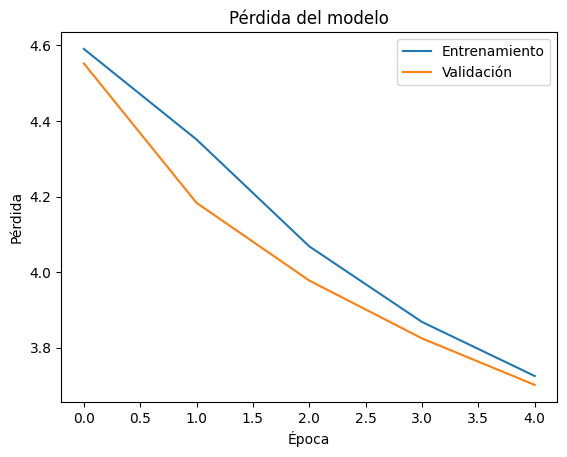

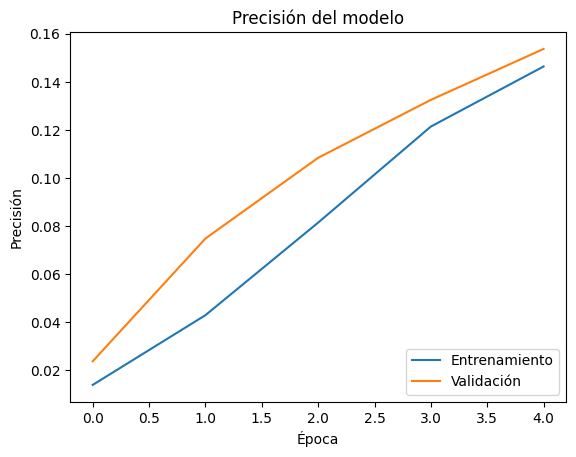

In [ ]:
# Imprimir las métricas de evaluación (pérdida y precisión, por ejemplo)
print(f'Pérdida en datos de prueba: {evaluacion[0]}')
print(f'Precisión en datos de prueba: {evaluacion[1]}')

# También puedes usar el historial del entrenamiento para visualizar las métricas de entrenamiento y validación a lo largo de las épocas
print(history.history.keys())  # Esto te dará las métricas disponibles en el historial

# Plotear la pérdida y la precisión durante el entrenamiento y la validación
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
plt.show()


# Matriz de confusión

La matriz de confusión es una herramienta utilizada en el campo de la clasificación para evaluar el rendimiento de un algoritmo. Es especialmente útil cuando se trata de problemas de clasificación multiclase, como el caso de CIFAR-100, que tiene 100 clases diferentes. La matriz organiza las predicciones del modelo en función de las clases reales a las que pertenecen los datos.

La diagonal principal representa las predicciones correctas para cada clase, mientras que las entradas fuera de la diagonal principal son los errores de clasificación.

Para evaluar la eficacia del modelo, se pueden calcular métricas adicionales a partir de la matriz de confusión, como la precisión, la sensibilidad y la especificidad para cada clase, así como la precisión global del modelo.




313/313 [==============================] - 1s 2ms/step


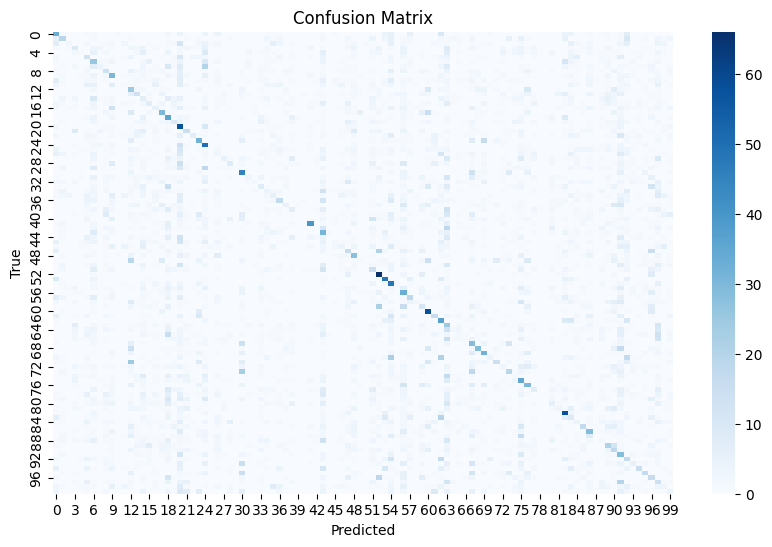

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Assuming 'model' is your trained model and 'test_images', 'test_labels' are your test data
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Convert one-hot encoded labels to class labels
true_labels = np.argmax(test_labels, axis=1)

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**Mejoras del modelo base**

Aunque los resultados obtenidos son superiores a la aleatoriedad (>0.01) no son los mejores posibles por lo que se prueba a añadir capas buscando la mejora.


```
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='softmax'))


model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_images_pure, train_labels_pure, batch_size=64,
                            epochs=5,
                            validation_data=(validation_images, validation_labels))

```

Añadir una tercera capa resulta eficiente, pero una cuarta no. Por lo que seleccionamos que el número óptimo de capas convolucionales son 3. Ahora nos queda determinar cual es el mejor valor de paso del kernel para las capas.

```
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((3, 3)))
model.add(Flatten())
model.add(Dense(100, activation='softmax'))


model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_images_pure, train_labels_pure, batch_size=64,
                            epochs=5,
                            validation_data=(validation_images, validation_labels))

```

3x3 resulta ser la dimensión que mejor aprende. Ahora se prueban con otros optimizadores que no sean sgd, como son adam y rmsprop

```
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((3, 3)))
model.add(Flatten())
model.add(Dense(100, activation='softmax'))


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_images_pure, train_labels_pure, batch_size=64,
                            epochs=5,
                            validation_data=(validation_images, validation_labels))

```

Adam resulta ser el optimizador que mejor funciona. Ahora se prueba a añadir una capa dense mas buscando buscar mayor profundidad. Además, para un mayor analisis de los resultados, ampliamos el numero de épocas.


```
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((3, 3)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(100, activation='softmax'))


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_images_pure, train_labels_pure, batch_size=64,
                            epochs=15,
                            validation_data=(validation_images, validation_labels))

```

Añadir una capa dense extra resulta mejorar el modelo, por lo que se prueba a añadir aun mas capas de este tipo. Determinamos que el número optimo de estas capas anterior a la capa de salida es de 2.

```
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((3, 3)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(100, activation='softmax'))


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_images_pure, train_labels_pure, batch_size=64,
                            epochs=15,
                            validation_data=(validation_images, validation_labels))
```

Ahora buscamos crear un modelo aun mas complejo para ver si su funcionamiento es mejor. Para ello empezaremos añadiendo mas capas convolucionales, pero esta vez de manera paralela. El crecimiento del validation accuracy se amplia de nuevo, por lo que requerimos mas épocas para el análisis.


```
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((3, 3)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(100, activation='softmax'))


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_images_pure, train_labels_pure, batch_size=64,
                            epochs=50,
                            validation_data=(validation_images, validation_labels))
```

Al añadir el paralelismo el modelo funciona de manera contundente, ante la mejora se prueba a añadir aun mas paralelismos pero el modelo no mejora, por lo que se emplea solamente paralelismo entre dos capas.

La siguiente prueba a realizar para hacer mas complejo el modelo es evitar el sobreentrenamiento, para ello se prueba a aplicar l1, l2, l1_l2 y dropout.


```
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_images_pure, train_labels_pure, batch_size=64,
                            epochs=50,
                            validation_data=(validation_images, validation_labels))
```

El dropout resulta ser el que mejor funciona y ademas mejora el modelo por lo que se emplea. Ahora se busca realizar una normalización de los datos despues de las capas, para ello se prueban la BatchNormalization, LayerNormalization, UnitNormalization y GroupNormalization.


```
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_images_pure, train_labels_pure, batch_size=64,
                            epochs=50,
                            validation_data=(validation_images, validation_labels))
```

BatchNormalization resulta ser el que mejor funciona.

Una vez habiendo realizado un aumento de la complejidad del modelo que conlleve una mejora significativa probamos a modificar los hiperparametros, para ello modificaremos el learning rate haciendolo reducir su valor segun la conveniencia de la época.

```
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=2,
                              min_lr=1e-5)


history = model.fit(train_images_pure, train_labels_pure, batch_size=64,
                            epochs=50,
                            validation_data=(validation_images, validation_labels),
                            callbacks=[reduce_lr])
```

Tras numerosas pruebas se determina que el learning rate de inicio debe ser de 0.001, con un descenso al 20% cada vez que las epocas empeoren 2 veces seguidas.

Ahora trabajaremos con los inputs que tenemos. Para ello aplicaremos features(caracteristicas) sobre las imagenes.


```
num_features = 20


# Create a separate input layer for the additional features
additional_input = Input(shape=(num_features,))


# Create the image model
model = Sequential()


# Convolutional layer 1
model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', input_shape=(32, 32, 3), activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


# Convolutional layer 2
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


# Convolutional layer 3
model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


# Flatten layer
model.add(Flatten())


# Concatenate the flattened image features with the additional features
combined_model = Concatenate()([model.output, additional_input])


# Fully-connected layer 1
combined_model = Dense(1024, activation='elu')(combined_model)
combined_model = BatchNormalization()(combined_model)
combined_model = Dropout(0.5)(combined_model)


# Fully-connected layer 2
combined_model = Dense(512, activation='elu')(combined_model)
combined_model = BatchNormalization()(combined_model)
combined_model = Dropout(0.5)(combined_model)


# Output layer with softmax activation for 100 classes in CIFAR-100
combined_model = Dense(100, activation='softmax')(combined_model)


# Create the combined model
final_model = tf.keras.Model(inputs=[model.input, additional_input], outputs=combined_model)


# Configure the optimizer with the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


# Compile the model
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Configure the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.2,
                              patience=2,
                              min_lr=1e-5)


# Assuming you have the additional features in a numpy array called additional_features
# Make sure to preprocess them appropriately
train_additional_features = np.random.random((len(train_images), num_features))
test_additional_features = np.random.random((len(test_images), num_features))


# Training the model with the callback ReduceLROnPlateau
history2 = final_model.fit([train_images, train_additional_features], train_labels, batch_size=64,
                            epochs=50,
                            validation_data=([test_images, test_additional_features], test_labels),
                            callbacks=[reduce_lr])
```

Tras numerosas pruebas determinamos que el numero optimo de features es de 20. Esto nos da la oportunidad de ir mucho mas rápido durante las primeras épocas.

Se añade otro modificador de learning rate centrado en la perdida de la validación

# Trabajo en equipo

La división del trabajo fue bastante equitativa y se pudo concentrar en diferentes campos. En un inicio fueron **Sandra** y **Natalia** quienes cargaron la base de datos desde la web, y fue **Ángel** quien le realizó las transformaciones de dimensiones para su correcta representación.


Durante la búsqueda de un modelo adecuado todos estuvimos buscando a través de diferentes fuentes de internet, sonsacando y uniendo la información que sacamos entre todos. De la misma manera se trabajó buscando una **buena representación de los datos** de entrada o mediante **data augmentation**, aunque al final estas técnicas no llegaron a ser empleadas más allá de los **features**.


Durante los últimos días el desarrollo del modelo ya estaba prácticamente completo y aunque se continuaban realizando investigaciones para una posible mejora nos centramos más en una correcta presentación del documento. Para ello **Natalia** se centró de manera principal en la **descripción teórica y técnica** de los pasos que íbamos realizando y el porqué. **Sandra** se encargó de los **parámetros**, la descripción del **modelo base**, y de **aspectos técnicos** del modelo final. **Ángel** se encargó principalmente del **desarrollo del modelo**, la **adecuación de los datos** y **análisis** de los resultados obtenidos.
